In [158]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
def hextofloats(h):
    '''Takes a hex rgb string (e.g. #ffffff) and returns an RGB tuple (float, float, float).'''
    return tuple(int(h[i:i + 2], 16) / 255. for i in (1, 3, 5)) # skip '#'


In [2]:
Aminoacid = ['Glycine betaine',
'Ectoine',
'GABA',
'Sarcosine',
'Taurine',
'Proline',
'Glutamate',
'Glutamine']
Aminoacid = sorted(Aminoacid)
Aminoacid.append('TMAO')
AminoAcid_cdict = dict(zip(Aminoacid, sns.color_palette("BuGn_r",len(Aminoacid))))

Sugars = ['Glycerol',
'Mannitol',
'Sorbitol',
'Sucrose',
'Trehalose'
]

Sugars_cdict = dict(zip(Sugars, sns.color_palette("BuPu_r",len(Sugars))))


color_order = [Aminoacid, Sugars]
color_order = [item for sublist in color_order for item in sublist]
color_dict_type = {**AminoAcid_cdict,  **Sugars_cdict}



In [3]:
def MMETSP_groupby(df, level='Division', normalized=True):
    division_MMETSP = df.merge(mmetsp_taxonomy[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = mmetsp_taxonomy.groupby(level)['Notes'].count()
    if normalized:
        division_MMETSP = division_MMETSP.T/total_per_group
        division_MMETSP = division_MMETSP.T
    return(division_MMETSP, total_per_group)
def create_cluster_bar(grouped_MMETSP, total_per_group, size=[12,12],
                       cutoff=False, c=5, genome=False, dropzero=False):
    grouped_MMETSP=grouped_MMETSP.dropna()
    if cutoff: 
        ii=total_per_group>c
        grouped_MMETSP= grouped_MMETSP.loc[ii]
        total_per_group=total_per_group[ii]
    if dropzero:
        ss= grouped_MMETSP[grouped_MMETSP.sum(axis=1)>0].index
        print(ss)
        grouped_MMETSP = grouped_MMETSP.loc[ss]
        total_per_group=total_per_group[ss]
    cluster = sns.clustermap(grouped_MMETSP, cmap='binary', yticklabels=1)
    cluster.fig.set_size_inches(size)
    
    # make some space to the right in the figure
    cluster.gs.update(right=0.95)
    # divide existing axes
    divider = make_axes_locatable(cluster.ax_heatmap)
    divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
    # create new axes for bar plot 
    ax = divider.append_axes("right", size="20%", pad=1.7)
    # create empty space of same size as bar plot axes (don't use this space)
    nax = divider2.new_horizontal(size="20%", pad=1.7)
    target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
    ind= np.array([list(grouped_MMETSP.index.values).index(t) for t in target])
    # plot bar plot in ax
    ax.barh(np.arange(len(target)), total_per_group.values[ind], color='k')
    ax.set_yticklabels([])
    ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    if genome:
        ax.set_xlabel('Total Genomes')
    else:
        ax.set_xlabel('Total Transcriptomes')
    ax.xaxis.set_label_position('top') 
    cluster.cax.set_position([0.1, .8, .02, 0.2])
    cluster.cax.set_ylabel('Proportion Gene present')

    plt.show()
    return(cluster)

def bact_groupby(df, level='phylum', normalized=True):
    division_bact = df.merge(MarRef[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = MarRef.groupby(level)['alt_elev'].count()
    if normalized:
        division_bact = division_bact.T/total_per_group
        division_bact = division_bact.T
    return(division_bact, total_per_group)

In [294]:
bact_synth = pd.read_csv('../predict_synthesis/2021-03-predicted-bacterial-osmolyte-synthesis.tsv', sep ='\t', header=[0, 1], index_col=0)

In [295]:
bact_synth.xs('BREAKDOWN', level=1, drop_level=False, axis=1).sum()

DMSP             BREAKDOWN     39
Ectoine          BREAKDOWN    137
GABA             BREAKDOWN    277
Glutamate        BREAKDOWN    897
Glutamine        BREAKDOWN    897
Glycerol         BREAKDOWN    691
Glycine betaine  BREAKDOWN      4
Hydroxyectoine   BREAKDOWN      0
Mannitol         BREAKDOWN    293
Proline          BREAKDOWN    897
Sarcosine        BREAKDOWN    263
Sorbitol         BREAKDOWN    333
Sucrose          BREAKDOWN    571
TMAO             BREAKDOWN      0
Taurine          BREAKDOWN    631
Trehalose        BREAKDOWN    281
dtype: int64

In [296]:
SYNTH = bact_synth.xs('SYNTHESIS', level=1, drop_level=False, axis=1)
BD = bact_synth.xs('BREAKDOWN', level=1, drop_level=False, axis=1)
SYNTH.columns = SYNTH.columns.droplevel(1)
BD.columns = BD.columns.droplevel(1)
MarRef = pd.read_csv('../MarRef_DBs/MarRef_v5.txt', sep='\t', index_col=44)
mmetsp_taxonomy = pd.read_csv('/vortexfs1/omics/alexander/data/mmetsp/taxonomy_v2.txt', sep='\t',
                              encoding = "ISO-8859-1", index_col='Source_ID')

MarRef['taxon_lineage_ids'] = MarRef['taxon_lineage_ids'].loc[SYNTH.index].str.replace('│','|')

ncbi = pd.read_csv('../MarRef_DBs/ncbi_assembly_info.tsv', sep='\t', index_col=0)
ncbi = ncbi.loc[ncbi.index.intersection(SYNTH.index)]
MarRef = MarRef.merge(ncbi, left_index=True, right_index=True)

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [297]:
summedbact = pd.DataFrame(SYNTH.sum()/len(SYNTH))
bd = pd.DataFrame(BD.sum()/len(BD))
summedbact=summedbact.merge(bd, left_index=True, right_index=True)
summedbact.columns=['SYNTHESIS', 'BREAKDOWN']
summedbact.sort_values('SYNTHESIS', ascending=False)

,SYNTHESIS,BREAKDOWN
Glutamate,1.000000,1.000000
Glutamine,0.997770,1.000000
Proline,0.934225,1.000000
Glycerol,0.484950,0.770346
Sorbitol,0.437012,0.371237
Glycine betaine,0.352285,0.004459
Sucrose,0.338907,0.636566
Mannitol,0.247492,0.326644
Taurine,0.243032,0.703456
Trehalose,0.212932,0.313266


In [298]:
alpha = MarRef[MarRef['class']=='Alphaproteobacteria'].index
ad = MarRef.loc[alpha].groupby('order').count()['base_ID'].to_dict()

cyanos = MarRef[MarRef.taxon_lineage_names.str.find('Cyano')!=-1].index
cd = MarRef.loc[cyanos].groupby('order').count()['base_ID'].to_dict()

gamma = MarRef[MarRef['class']=='Gammaproteobacteria'].index
gd = MarRef.loc[gamma].groupby('family').count()['base_ID'].to_dict()

archaea = MarRef[MarRef['kingdom']=='Archaea'].index
hd = MarRef.loc[archaea].groupby('phylum').count()['base_ID'].to_dict()


In [299]:
def genpgroups(indlist, level, dictset, cutoff):
    subset = MarRef.loc[indlist]
    for i in dictset.keys():
        if dictset[i]<=cutoff:
            subset.loc[subset[level]==i, 'plotting_group']='Other'
        else:
            subset.loc[subset[level]==i, 'plotting_group']=i
    S = pd.DataFrame(subset['plotting_group']).merge(SYNTH, left_index=True, right_index=True)
    B = pd.DataFrame(subset['plotting_group']).merge(BD, left_index=True, right_index=True)
    SS = S.groupby('plotting_group').sum()
    BB = B.groupby('plotting_group').sum()

    SS['total'] = S.groupby('plotting_group').count()['DMSP']
    BB['total'] = B.groupby('plotting_group').count()['DMSP']
    outdict ={'S': SS, 'B':BB} 
    return(outdict)


In [300]:
alpha = MarRef[MarRef['class']=='Alphaproteobacteria'].index
ad = MarRef.loc[alpha].groupby('order').count()['base_ID'].to_dict()

cyanos = MarRef[MarRef.taxon_lineage_names.str.find('Cyano')!=-1].index
cd = MarRef.loc[cyanos].groupby('family').count()['base_ID'].to_dict()

gamma = MarRef[MarRef['class']=='Gammaproteobacteria'].index
gd = MarRef.loc[gamma].groupby('order').count()['base_ID'].to_dict()

archaea = MarRef[MarRef['kingdom']=='Archaea'].index
hd = MarRef.loc[archaea].groupby('phylum').count()['base_ID'].to_dict()





alphaSB = genpgroups(alpha, 'order', ad, 3)
gammaSB  = genpgroups(gamma, 'order', gd, 4)
cyanoSB = genpgroups(cyanos, 'family', cd, 4)
arcSB = genpgroups(archaea, 'phylum', hd, 0)
all_dict = {'Alpha': alphaSB, 'Gamma': gammaSB, 'Cyano': cyanoSB, 'Archeae': arcSB}

Alpha
Gamma
Cyano
Archeae


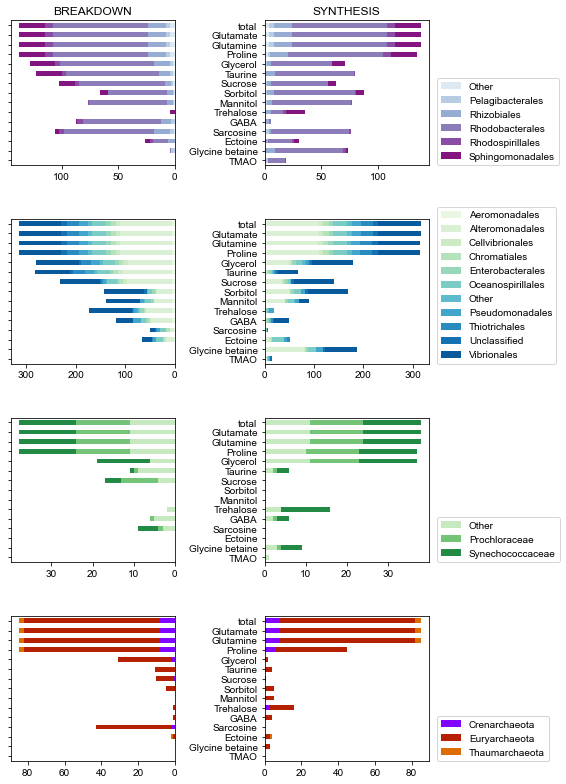

In [302]:
order = ['TMAO', 'Glycine betaine', 'Ectoine',
       'Sarcosine', 'GABA', 'Trehalose', 'Mannitol', 'Sorbitol', 'Sucrose',
       'Taurine', 'Glycerol', 'Proline', 'Glutamine', 'Glutamate', 'total']
colors = ['BuPu', 'GnBu', 'Greens', 'gnuplot']
fig, ax = plt.subplots(4,2, figsize=[8,11])
for a, o, c in zip(ax, all_dict.keys(), colors):
    print(o)
    sg = all_dict[o]['S']
    bg = all_dict[o]['B']
    sg[order].T.plot(kind='barh', stacked=True, ax=a[1], color=sns.color_palette(c, len(all_dict[o]['S'].index)))
    bg[order].T.plot(kind='barh', stacked=True, ax=a[0], legend=None ,  color=sns.color_palette(c, len(all_dict[o]['S'].index)))
    a[1].legend(loc=(1.05, 0))
    a[0].invert_xaxis()
    a[0].set_yticklabels([]);
    
ax[0][0].set_title('BREAKDOWN')
ax[0][1].set_title('SYNTHESIS')
fig.tight_layout()
fig.savefig('figures/Groups-Syn_BD.pdf')